In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print(os.listdir('.'))
print('Python      :', sys.version.split('\n')[0])
print('Numpy       :', np.__version__)
print('Tensorflow  :', tf.__version__)
print('Keras       :', tf.__version__)

['2. MNIST2.ipynb', 'Влияние learning rate и масштаба признаков на сходимость.ipynb', 'requirements.txt', '5. Transfer learning in color classification.ipynb', 'flower', '1. MNIST_INTRO.ipynb', '3. Keras conv.ipynb', '.ipynb_checkpoints']
Python      : 3.8.12 | packaged by conda-forge | (default, Sep 29 2021, 19:21:23) 
Numpy       : 1.23.5
Tensorflow  : 2.13.0
Keras       : 2.13.0


In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
!pip freeze > requirements.txt

# Setup

In [13]:
# Выносим в setup основные настройки, так удобнее их акркьирать в дальнейшем

EPOCHS        = 50
BATCH_SIZE    = 128
LR            = 1e-3
VAL_SPLIT     = .2

CLASS_NUM     = 102
IMG_SIZE      = 128
IMG_CHANNELS  = 3
input_shape   = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../datasets/flower-dataset-102/'
PATH = 'flower/'

In [14]:
os.makedirs(PATH, exist_ok=False)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

# Data

In [16]:
# проситаемм все названия файлов прямо из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]
    
df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+'102flowers.tgz'))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1 # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [17]:
df.head()

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [18]:
df['Category'].value_counts()

Category
50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: count, Length: 102, dtype: int64

<Axes: ylabel='Category'>

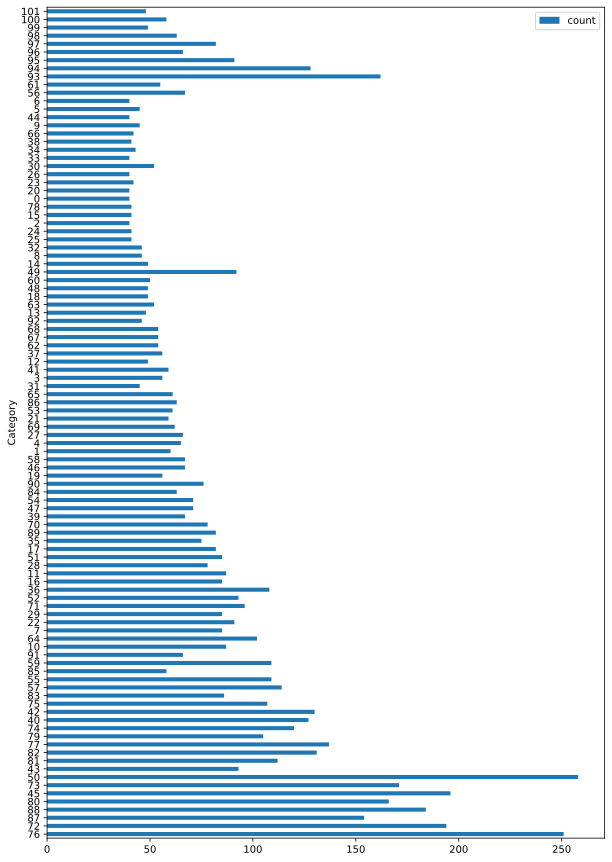

In [20]:
pd.DataFrame(df['Category'].value_counts(sort=False)).plot(kind='barh', figsize=(10, 15))

In [21]:
df['Category'].nunique()

102

In [22]:
print('Распаковываем картинки')
# Will untar he files so that you can see them...
opened_tar = tarfile.open(DATA_PATH+'102flowers.tgz')
opened_tar.extractall(PATH)

print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_07088.jpg', 'image_06396.jpg', 'image_05847.jpg', 'image_04581.jpg', 'image_03588.jpg']


Пример картинок (random sample)


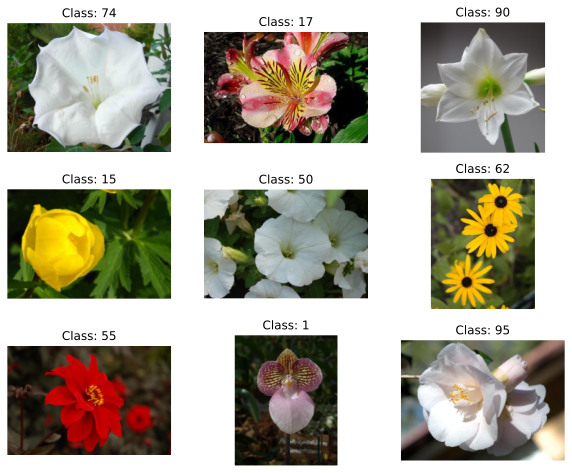

In [23]:
print('Пример картинок (random sample)')
plt.figure(figsize=(10, 8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


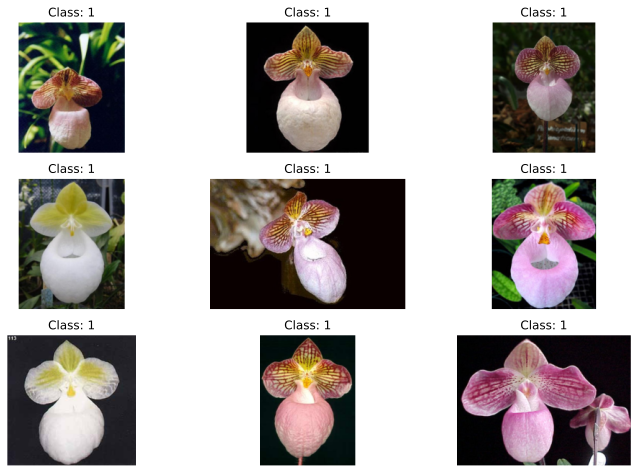

In [24]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12, 8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3, 3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

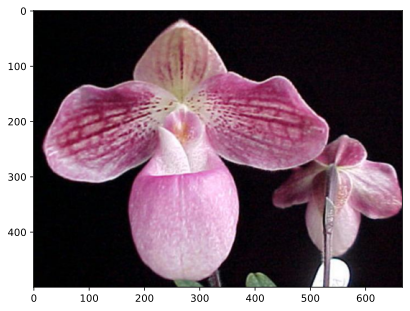

(667, 500)

In [26]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

# Strarify Split

In [28]:
# train / test
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=.2, random_state=42, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [29]:
train_files.head()

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [30]:
train_files['Category'].value_counts()

Category
50    206
76    201
45    157
72    155
88    147
     ... 
0      32
6      32
33     32
2      32
26     32
Name: count, Length: 102, dtype: int64

In [31]:
test_files['Category'].value_counts()

Category
50    52
76    50
72    39
45    39
88    37
      ..
78     8
0      8
20     8
24     8
66     8
Name: count, Length: 102, dtype: int64

# Data augmentation

In [41]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# datagen

In [43]:
# 'Заворачиваем' наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    bath_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    bath_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из train_generator


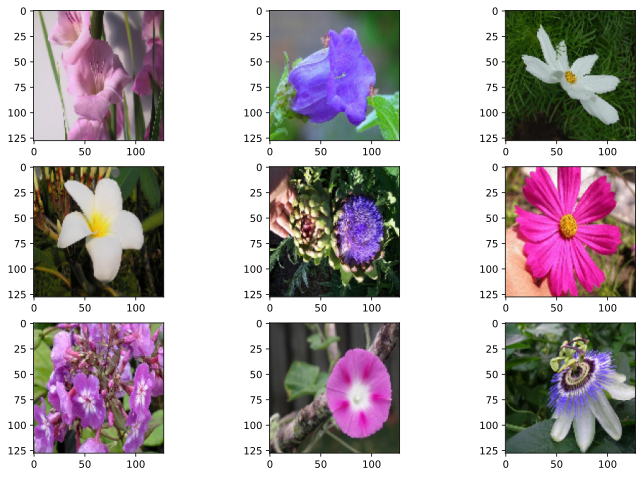

In [46]:
from skimage import io

def imshow(imgage_RGB):
    io.imshow(image_RGB)
    io.show()
    
x, y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12, 8))

for i in range(0, 9):
    image = x[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


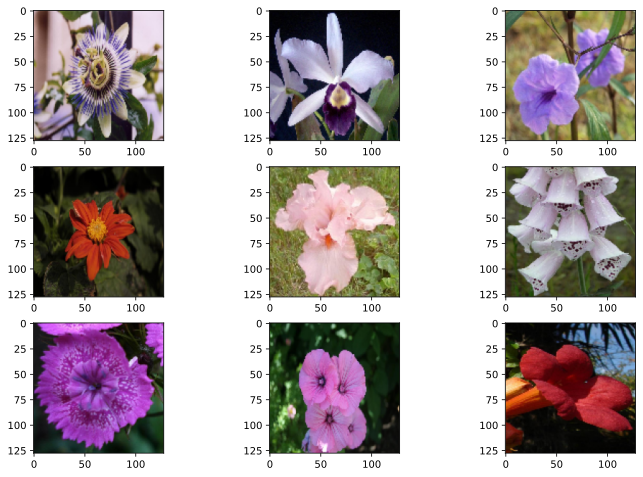

In [48]:
x, y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12, 8))

for i in range(0, 9):
    image = x[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [49]:
input_shape

(128, 128, 3)